# Imports

In [12]:
import os
from datetime import datetime
import seaborn as sns
import  xarray as xr
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
warnings.filterwarnings("ignore")

# Functions

In [50]:
def read_aeronet(filename): 
    """
    Reads an AERONET data file and returns a cleaned pandas DataFrame.

    This function reads AERONET (AErosol RObotic NETwork) data from a text file, 
    parsing the date and time columns to create a datetime index. It removes 
    rows and columns that consist entirely of missing data. The function also 
    renames certain columns for clarity.

    Parameters:
    filename (str): Path to the AERONET data file.

    Returns:
    DataFrame: A cleaned DataFrame with AERONET data, indexed by observation timestamps.
    """
    dateparse =  lambda x: pd.to_datetime(x, format="%d:%m:%Y %H:%M:%S")
    aeronet = pd.read_csv(filename,skiprows=0 , na_values=['N/A'],
                          parse_dates={'times':[0,1]},
                          date_parser=dateparse)

    aeronet = aeronet.set_index('times')
    
    # Drop any rows that are all NaN and any cols that are all NaN then sort by the index
    an = (aeronet.dropna(axis=1, how='all')
                .dropna(axis=0, how='all')
                .rename(columns={'Last_Processing_Date(dd/mm/yyyy)': 'Last_Processing_Date'})
                .sort_index())

    return an

In [4]:
def clean(x):
    """
    Replaces values less than -1 with NaN.

    Parameters:
    x (numeric): The value to be checked and cleaned.

    Returns:
    numeric: Original value if >= -1, otherwise NaN.
    """
    if x < -1:
        return np.nan
    else:
        return x

In [5]:
def resampler_AOD(df):
    """
    Cleans, resamples, and filters AERONET site DataFrame containing AOD and Angstrom Exponent data.

    This function first applies cleaning to the 'AOD_675nm' and 'Angstrom_440-870' columns, 
    then resamples the data to an hourly frequency, and finally filters out rows based 
    on specific conditions for 'Angstrom_440-870'.

    Parameters:
    df (DataFrame): A DataFrame with an index of datetime, containing columns 'AOD_675nm' 
                    and '440-870_Angstrom_Exponent'.

    Returns:
    DataFrame: A processed DataFrame resampled to hourly intervals, with NaN rows and rows 
               where '440-870_Angstrom_Exponent' is more than 0.75 dropped.
    """
    df.AOD_675nm = df.AOD_675nm.apply(clean)
    df["Angstrom_440-870"] = df["440-870_Angstrom_Exponent"].apply(clean)
    
    df = df[[ "AOD_675nm" , "Angstrom_440-870"]]
    df["date"] = df.index
    df['start_time'] = df.date.dt.round('h')
    df = df.resample('60min').mean()
    df = df.dropna(axis = 0, how = 'all')
    #
    # Drop rows where Angstrom_440_675 is more than 0.75
    df = df[df['Angstrom_440-870'] <= 0.75]
    #
   
    return df

In [6]:
def extract_after_second_underscore(s, n):
    """
    Extracts a substring from a filename, typically a site name, after the second underscore.

    This function is designed to parse filenames where site names or relevant information 
    are placed after the second underscore. It returns the substring found after the second 
    underscore and truncates 'n' characters from the end of this substring.

    Parameters:
    s (str): The string representing the filename from which to extract the site name.
    n (int): The number of characters to omit from the end of the extracted substring.

    Returns:
    str: The extracted site name if the string contains at least two underscores,
         otherwise a message indicating insufficient underscores in the string.
    """
    parts = s.split('_')
    if len(parts) >= 3:
        return '_'.join(parts[2:])[:-n-1]
    else:
        return "Not enough underscores in string"

# Aeronet

area stretches from 5.625° to 42.375° latitude and from -11.625° to 77.375° longitude,

In [7]:

# Read sites information into a DataFrame, skipping the first row
df = pd.read_csv("Aeronet/aeronet.gsfc.nasa.gov_aeronet_locations_v3.txt", skiprows=1)
# Define the geographical bounds
lat_min = 5.625 + 2
lat_max = 42.375 - 2
lon_min = -11.625 + 2 
lon_max = 77.375 - 2

# Filter the DataFrame to include only sites within the specified area
aeronet = df[(df['Latitude(decimal_degrees)'] >= lat_min) &
                 (df['Latitude(decimal_degrees)'] <= lat_max) &
                 (df['Longitude(decimal_degrees)'] >= lon_min) &
                 (df['Longitude(decimal_degrees)'] <= lon_max)]
# Reset the index
aeronet = aeronet.reset_index(drop=True)

# Drop the elevation column
aeronet = aeronet.drop('Elevation(meters)', axis=1)

# Rename the longitude and latitude columns
aeronet = aeronet.rename(columns={'Longitude(decimal_degrees)': 'lon', 'Latitude(decimal_degrees)': 'lat'})


In [8]:
aeronet

,Site_Name,lon,lat
0,Bondoukoui,-3.750000,11.850000
1,Bidi_Bahn,-2.450000,14.060000
2,Ouagadougou,-1.487230,12.424130
3,SEDE_BOKER,34.782222,30.855000
4,Banizoumbou,2.665190,13.546930
...,...,...,...
164,University_of_Nizwa,57.674100,22.910100
165,Guadiana_UGR_4,-3.227570,37.915013
166,AAU_Jackros_ET,38.820833,9.011667
167,Riyadh_Airport_SDSC,46.721710,24.925833


In [10]:
dirname = "Aeronet/AOD20/AOD20/ALL_POINTS/" # change to directory containing the aeronet files
i=0
aeronet_files = []

# Loop through files in the specified directory and add them to aeronet_files list

for file in os.listdir( dirname):
    aeronet_files.append(file)
    
files_in_region = []

# Iterate over each file in aeronet_files and keep ones only that are in specified bounds
for file_name in aeronet_files:
    extracted_name = extract_after_second_underscore(file_name,5)
    if extracted_name in aeronet['Site_Name'].values:
        files_in_region.append(file_name)

In [15]:
# Initialize empty lists for files that pass certain conditions and final sites,
# as well as a dictionary to hold AERONET data
files_in_time= []
final_sites = []
aeronet_dict={}

# Define the date range of interest
start_date = "2017-12-01"
end_date = "2022-11-30"

# Loop through all the files in the specified region
for file in files_in_region:
    # Extract the name from the file, starting at the 19th character, and ending before '.ONEILL'
    extracted_name = extract_after_second_underscore(file,5)
    aeronet_site =  read_aeronet(dirname+file)
    aeronet_site = resampler_AOD(aeronet_site)

    # Filter the data to the specified date range
    aeronet_site = aeronet_site[(aeronet_site.index >= start_date) & (aeronet_site.index <= end_date)]
    
    # Resample the data to daily frequency and drop missing values, for checking later
    check_days= aeronet_site.resample('D').mean().dropna()

    
    # If more than 30 days of data are present, process the file as "GOOD"
    if len(check_days)>30:
        files_in_time.append(file)
        final_sites.append(extracted_name)
        # Store site DataFrame into dictionary
        aeronet_dict[extracted_name]=aeronet_site
        print("Sufficent" , file )
    else:
        # If not enough data is present, mark the file as "BAD"
        print("NOT Sufficent", file)


Sufficent 19930101_20230902_AAU_ET.lev20
NOT Sufficent 19930101_20230902_AAU_Jackros_ET.lev20
NOT Sufficent 19930101_20230902_Abu_Al_Bukhoosh.lev20
NOT Sufficent 19930101_20230902_Abu_Dhabi.lev20
Sufficent 19930101_20230902_AgiaMarina_Xyliatou.lev20
NOT Sufficent 19930101_20230902_Agoufou.lev20
NOT Sufficent 19930101_20230902_Ahi_De_Cara.lev20
NOT Sufficent 19930101_20230902_Ahmedabad.lev20
Sufficent 19930101_20230902_Albergue_UGR.lev20
NOT Sufficent 19930101_20230902_Alboran.lev20
NOT Sufficent 19930101_20230902_Al_Ain.lev20
NOT Sufficent 19930101_20230902_Al_Dhafra.lev20
NOT Sufficent 19930101_20230902_Al_Khaznah.lev20
NOT Sufficent 19930101_20230902_Al_Qlaa.lev20
Sufficent 19930101_20230902_Antikythera_NOA.lev20
Sufficent 19930101_20230902_Aras_de_los_Olmos.lev20
NOT Sufficent 19930101_20230902_Armilla.lev20
Sufficent 19930101_20230902_ATHENS-NOA.lev20
Sufficent 19930101_20230902_ATHENS_NTUA.lev20
Sufficent 19930101_20230902_Badajoz.lev20
NOT Sufficent 19930101_20230902_Bahrain.lev2

In [16]:
print("Number of sites avaliable for validation" , len(files_in_time))

Number of sites avaliable for validation 59


In [17]:
# Filter the 'aeronet' DataFrame to include only rows where 'Site_Name' matches values in 'final_sites' those that have sufficient data.

aeronet = aeronet[aeronet.Site_Name.isin( final_sites)]
aeronet = aeronet.reset_index(drop=True)

# SEVIRI

In [19]:
# Read the data of plumes, inluding lats and lons
dust_scan = xr.open_dataset('DustSCAN_2022.nc')
lons = dust_scan.longitude.values
lats = dust_scan.latitude.values

In [20]:
def find_closest_indices(lat_matrix, lon_matrix, lat, lon):
    """
    Finds the indices of the closest latitude and longitude in the given matrices.
    If the closest latitude or longitude are more than 2 units apart from the values
    in the matrix, NaN values are returned.
    
    Parameters:
    lat_matrix: 2D numpy array of latitudes
    lon_matrix: 2D numpy array of longitudes
    lat: Target latitude
    lon: Target longitude
    
    Returns:
    Tuple of indices (i, j) representing the closest latitude and longitude in the matrices, 
    or (nan, nan) if the closest values are more than 2 units apart
    """
    # Compute the Euclidean distance between the given point and all points in the matrices
    distance_matrix = np.sqrt((lat_matrix - lat)**2 + (lon_matrix - lon)**2)

    # Find the indices of the minimum distance
    min_lat_idx, min_lon_idx = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

    # Check if the closest latitude or longitude are more than 2 units apart from the given values
    if abs(lat_matrix[min_lat_idx, min_lon_idx] - lat) > 2 or abs(lon_matrix[min_lat_idx, min_lon_idx] - lon) > 2:
        return np.nan, np.nan

    return int(min_lat_idx), int(min_lon_idx)


In [24]:
def get_site_labels(lat_idx,lon_idx):
    """
    Extracts and compiles dust event labels for specified latitude and longitude indices over multiple years.

    This function iterates over a predefined list of years, opening dust event datasets for each year. 
    It then identifies dust event occurrences based on a multi-layer neighbor-checking algorithm that checks a 1.5 degree radius. 
    The function aggregates dates and dust event flags across years into a DataFrame.

    Parameters:
    lat_idx (int): Latitude index for the location of interest.
    lon_idx (int): Longitude index for the location of interest.

    Returns:
    DataFrame: A pandas DataFrame containing two columns: 'date' and 'flag'.
               'date' represents the dates of observations, and 'flag' indicates 
               whether a dust event was detected (True) or not (False) for each date.

    Note:
    The function relies on specific file naming and structure for the dust event datasets,
    as well as a predetermined set of shifts to check neighboring cells (1.5 degrees) for dust events.
    """
    all_dates=[]
    all_values=[]
    years = [2018,2019,2020,2021,2022]
    # Loop over the years
    for year in years:
        print(year)
        dust_scan = xr.open_dataset("DustSCAN_"+str(year)+".nc")
        labels = dust_scan["plume_ID"].values > 0
        dates= dust_scan["time"].values

        shifts =   [  # Sixth layer (6 cells away from the center)
            (-6, 0), (6, 0), (0, -6), (0, 6),

            # Fifth layer (5 cells away from the center)
            (-5, -3), (-5, -2), (-5, -1), (-5, 0), (-5, 1), (-5, 2), (-5, 3),
            (5, -3), (5, -2), (5, -1), (5, 0), (5, 1), (5, 2), (5, 3),
            (-3, -5), (-2, -5), (-1, -5), (0, -5), (1, -5), (2, -5), (3, -5),
            (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5),

            # Fourth layer (4 cells away from the center)
            (-4, -4), (-4, -3), (-4, -2), (-4, -1), (-4, 0), (-4, 1), (-4, 2), (-4, 3), (-4, 4),
            (4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4),
            (-3, -4), (-2, -4), (-1, -4), (0, -4), (1, -4), (2, -4), (3, -4),
            (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4),

            # Third layer (3 cells away from the center)
            (-3, -3), (-3, -2), (-3, -1), (-3, 0), (-3, 1), (-3, 2), (-3, 3),
            (3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3),
            (-2, -3), (-1, -3), (0, -3), (1, -3), (2, -3),
            (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3),

            # Second layer (2 cells away from the center)
            (-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2),
            (2, -2), (2, -1), (2, 0), (2, 1), (2, 2),
            (-1, -2), (0, -2), (1, -2),
            (-1, 2), (0, 2), (1, 2),

            # First layer (1 cell away from the center)
            (-1, -1), (-1, 0), (-1, 1),
            (1, -1), (1, 0), (1, 1),
            (0, -1), (0, 1),

            # Central cell
            (0, 0)
        ]

        neighbors=[]
        # Loop through shifts and set the flags
        for shift in shifts:
            lat_shift, lon_shift = shift
            y = int(lat_idx) + lat_shift
            x = int(lon_idx) + lon_shift
            neighbors.append( labels[:, y , x ])
            
        # Stack the neighbors into a 2D array
        neighbors_array = np.stack(neighbors, axis=-1)
        # Use logical OR along the desired axis to check if any neighbor is True
        values = np.any(neighbors_array, axis=-1)


        #
        all_dates.append(dates)
        all_values.append(values)

    df_site= pd.DataFrame()
    df_site["date"]= np.concatenate(all_dates)
    df_site["flag"]= np.concatenate(all_values)
    
    return df_site

In [25]:
indices_df = aeronet.apply(lambda row: pd.Series(find_closest_indices(lats, lons, row['lat'], row['lon']), index=['lat_idx', 'lon_idx']), axis=1)
aeronet_with_indices = pd.concat([aeronet, indices_df], axis=1)


In [26]:
n=0
seviri_dict = {}
for index, row in aeronet_with_indices.iterrows():
    site_name = row['Site_Name']
    print(n, site_name)
    n+=1
    lat = row['lat']
    lon = row['lon']
    lat_idx = int(row['lat_idx'])
    lon_idx = int(row['lon_idx'])
    
    # Call the function 'get_site_labels' with latitude and longitude indices
    df = get_site_labels(lat_idx,lon_idx)
    # Store the returned DataFrame in 'seviri_dict' with the site name as the key
    seviri_dict[site_name] = df

0 SEDE_BOKER
2018
2019
2020
2021
2022
1 Banizoumbou
2018
2019
2020
2021
2022
2 Ilorin
2018
2019
2020
2021
2022
3 IMS-METU-ERDEMLI
2018
2019
2020
2021
2022
4 El_Arenosillo
2018
2019
2020
2021
2022
5 Lampedusa
2018
2019
2020
2021
2022
6 Lecce_University
2018
2019
2020
2021
2022
7 Kuwait_University
2018
2019
2020
2021
2022
8 ATHENS-NOA
2018
2019
2020
2021
2022
9 Evora
2018
2019
2020
2021
2022
10 Cabo_da_Roca
2018
2019
2020
2021
2022
11 Messina
2018
2019
2020
2021
2022
12 IER_Cinzana
2018
2019
2020
2021
2022
13 Granada
2018
2019
2020
2021
2022
14 Mezaira
2018
2019
2020
2021
2022
15 Saada
2018
2019
2020
2021
2022
16 Pune
2018
2019
2020
2021
2022
17 Tamanrasset_INM
2018
2019
2020
2021
2022
18 Karachi
2018
2019
2020
2021
2022
19 Lahore
2018
2019
2020
2021
2022
20 Eilat
2018
2019
2020
2021
2022
21 Burjassot
2018
2019
2020
2021
2022
22 Zinder_Airport
2018
2019
2020
2021
2022
23 IASBS
2018
2019
2020
2021
2022
24 CUT-TEPAK
2018
2019
2020
2021
2022
25 Dushanbe
2018
2019
2020
2021
2022
26 Tabernas_

# Clouds

In [27]:
def get_site_labels_clouds(lat_idx,lon_idx):
    """
    Retrieves cloud mask labels for a specific site over multiple years.

    This function iterates over a set list of years, opening cloud mask datasets for each year. 
    It extracts cloud mask data specifically for the given latitude and longitude indices. 
    The function compiles and returns this data in a DataFrame, with each row corresponding to 
    a specific date and its associated cloud mask value.

    Parameters:
    lat_idx (int): The latitude index for the site of interest.
    lon_idx (int): The longitude index for the site of interest.

    Returns:
    DataFrame: A pandas DataFrame with two columns: 'dates' and 'cl_mask'.
               'dates' is a series of dates corresponding to the dataset entries, and 
               'cl_mask' contains the cloud mask values for the specified site at each date.

    Note:
    The function assumes a specific directory structure and naming convention for the cloud mask datasets.
    """
    all_dates=[]
    all_values=[]
    years = [2018,2019,2020,2021,2022]
    # Loop over the years
    for year in years:
        # Loop over the seasons
        print(year)
        ds = xr.open_dataset("DustSCAN_"+str(year)+".nc")
        dates= ds["time"].values
        cloud_m = ds["cloud_mask"].values
        site_cloud = cloud_m [:, int(lat_idx), int(lon_idx)]
        #
        all_dates.append(dates)
        all_values.append(site_cloud)

    df_site= pd.DataFrame()
    df_site["dates"]= np.concatenate(all_dates)
    df_site["cl_mask"]= np.concatenate(all_values)
    
    return df_site

In [28]:
n=0
cloud_dict = {}
for index, row in aeronet_with_indices.iterrows():
    site_name = row['Site_Name']
    print(n, site_name)
    n+=1
    lat = row['lat']
    lon = row['lon']
    lat_idx = int(row['lat_idx'])
    lon_idx = int(row['lon_idx'])
    df = get_site_labels_clouds(lat_idx,lon_idx)
    cloud_dict[site_name] = df

0 SEDE_BOKER
2018
2019
2020
2021
2022
1 Banizoumbou
2018
2019
2020
2021
2022
2 Ilorin
2018
2019
2020
2021
2022
3 IMS-METU-ERDEMLI
2018
2019
2020
2021
2022
4 El_Arenosillo
2018
2019
2020
2021
2022
5 Lampedusa
2018
2019
2020
2021
2022
6 Lecce_University
2018
2019
2020
2021
2022
7 Kuwait_University
2018
2019
2020
2021
2022
8 ATHENS-NOA
2018
2019
2020
2021
2022
9 Evora
2018
2019
2020
2021
2022
10 Cabo_da_Roca
2018
2019
2020
2021
2022
11 Messina
2018
2019
2020
2021
2022
12 IER_Cinzana
2018
2019
2020
2021
2022
13 Granada
2018
2019
2020
2021
2022
14 Mezaira
2018
2019
2020
2021
2022
15 Saada
2018
2019
2020
2021
2022
16 Pune
2018
2019
2020
2021
2022
17 Tamanrasset_INM
2018
2019
2020
2021
2022
18 Karachi
2018
2019
2020
2021
2022
19 Lahore
2018
2019
2020
2021
2022
20 Eilat
2018
2019
2020
2021
2022
21 Burjassot
2018
2019
2020
2021
2022
22 Zinder_Airport
2018
2019
2020
2021
2022
23 IASBS
2018
2019
2020
2021
2022
24 CUT-TEPAK
2018
2019
2020
2021
2022
25 Dushanbe
2018
2019
2020
2021
2022
26 Tabernas_

# Combine

In [29]:
"""
This script merges data from different sources (AERONET, SEVIRI, and cloud observations) for a list of specified sites. 
Each site has associated data in separate DataFrames stored in different dictionaries (aeronet_dict, seviri_dict, 
and cloud_dict). For each site, the corresponding DataFrames are merged based on date indices to synchronize 
observations across different datasets.

The script iterates through each site in 'final_sites', merging the relevant DataFrames from each dictionary.
The merged data includes AERONET aerosol properties, SEVIRI-derived products, and cloud mask data. 
The final merged DataFrame for each site includes a combination of these datasets with consistent date indexing, 
enhancing the analysis of aerosol and cloud properties over time at each location. 

The merged DataFrames are stored in a dictionary 'merged_dict_combo' keyed by site names and are also collected in 
a list 'dfs' for further processing or analysis.
"""


merged_dict_combo = {}
dfs=[]
#

for site in final_sites:
    aero_df = aeronet_dict[site]
    #
    sev_df = seviri_dict[site]
    sev_df = sev_df.set_index('date')

    #
    cloud_df = cloud_dict[site]
    cloud_df = cloud_df.set_index('dates')
    
    merged_df_1 = pd.merge(aero_df, sev_df, left_index=True, right_index=True , how='inner')

    merged_df_2 = pd.merge(merged_df_1, cloud_df, left_index=True, right_index=True, how='inner')

    merged_df_2["date"] = merged_df_2.index
    merged_df_2["site"] = site
    # The final_merged_df DataFrame now contains only rows where the date exists in all three original DataFrames.
    merged_dict_combo[site] = merged_df_2
    dfs.append(merged_df_2)

In [30]:
# Group all site combined data in one DataFrame
concatenated_df= pd.concat(dfs, ignore_index=True)

# Add a new boolean column 'keep' to 'concatenated_df' based on logical operations involving dust 'flag' and 'cl_mask' columns
concatenated_df['keep'] = (
    concatenated_df['flag']  # Condition 1: If 'flag' is True, 'keep' will be True
    |  # Logical OR operator
    (~concatenated_df['flag'] & ~concatenated_df['cl_mask'])  # Condition 2: 'keep' will also be True if BOTH 'flag' is False AND 'cl_mask' is False
)

concatenated_df = concatenated_df[concatenated_df["keep"]]
concatenated_df = concatenated_df.dropna(subset=['AOD_675nm'])


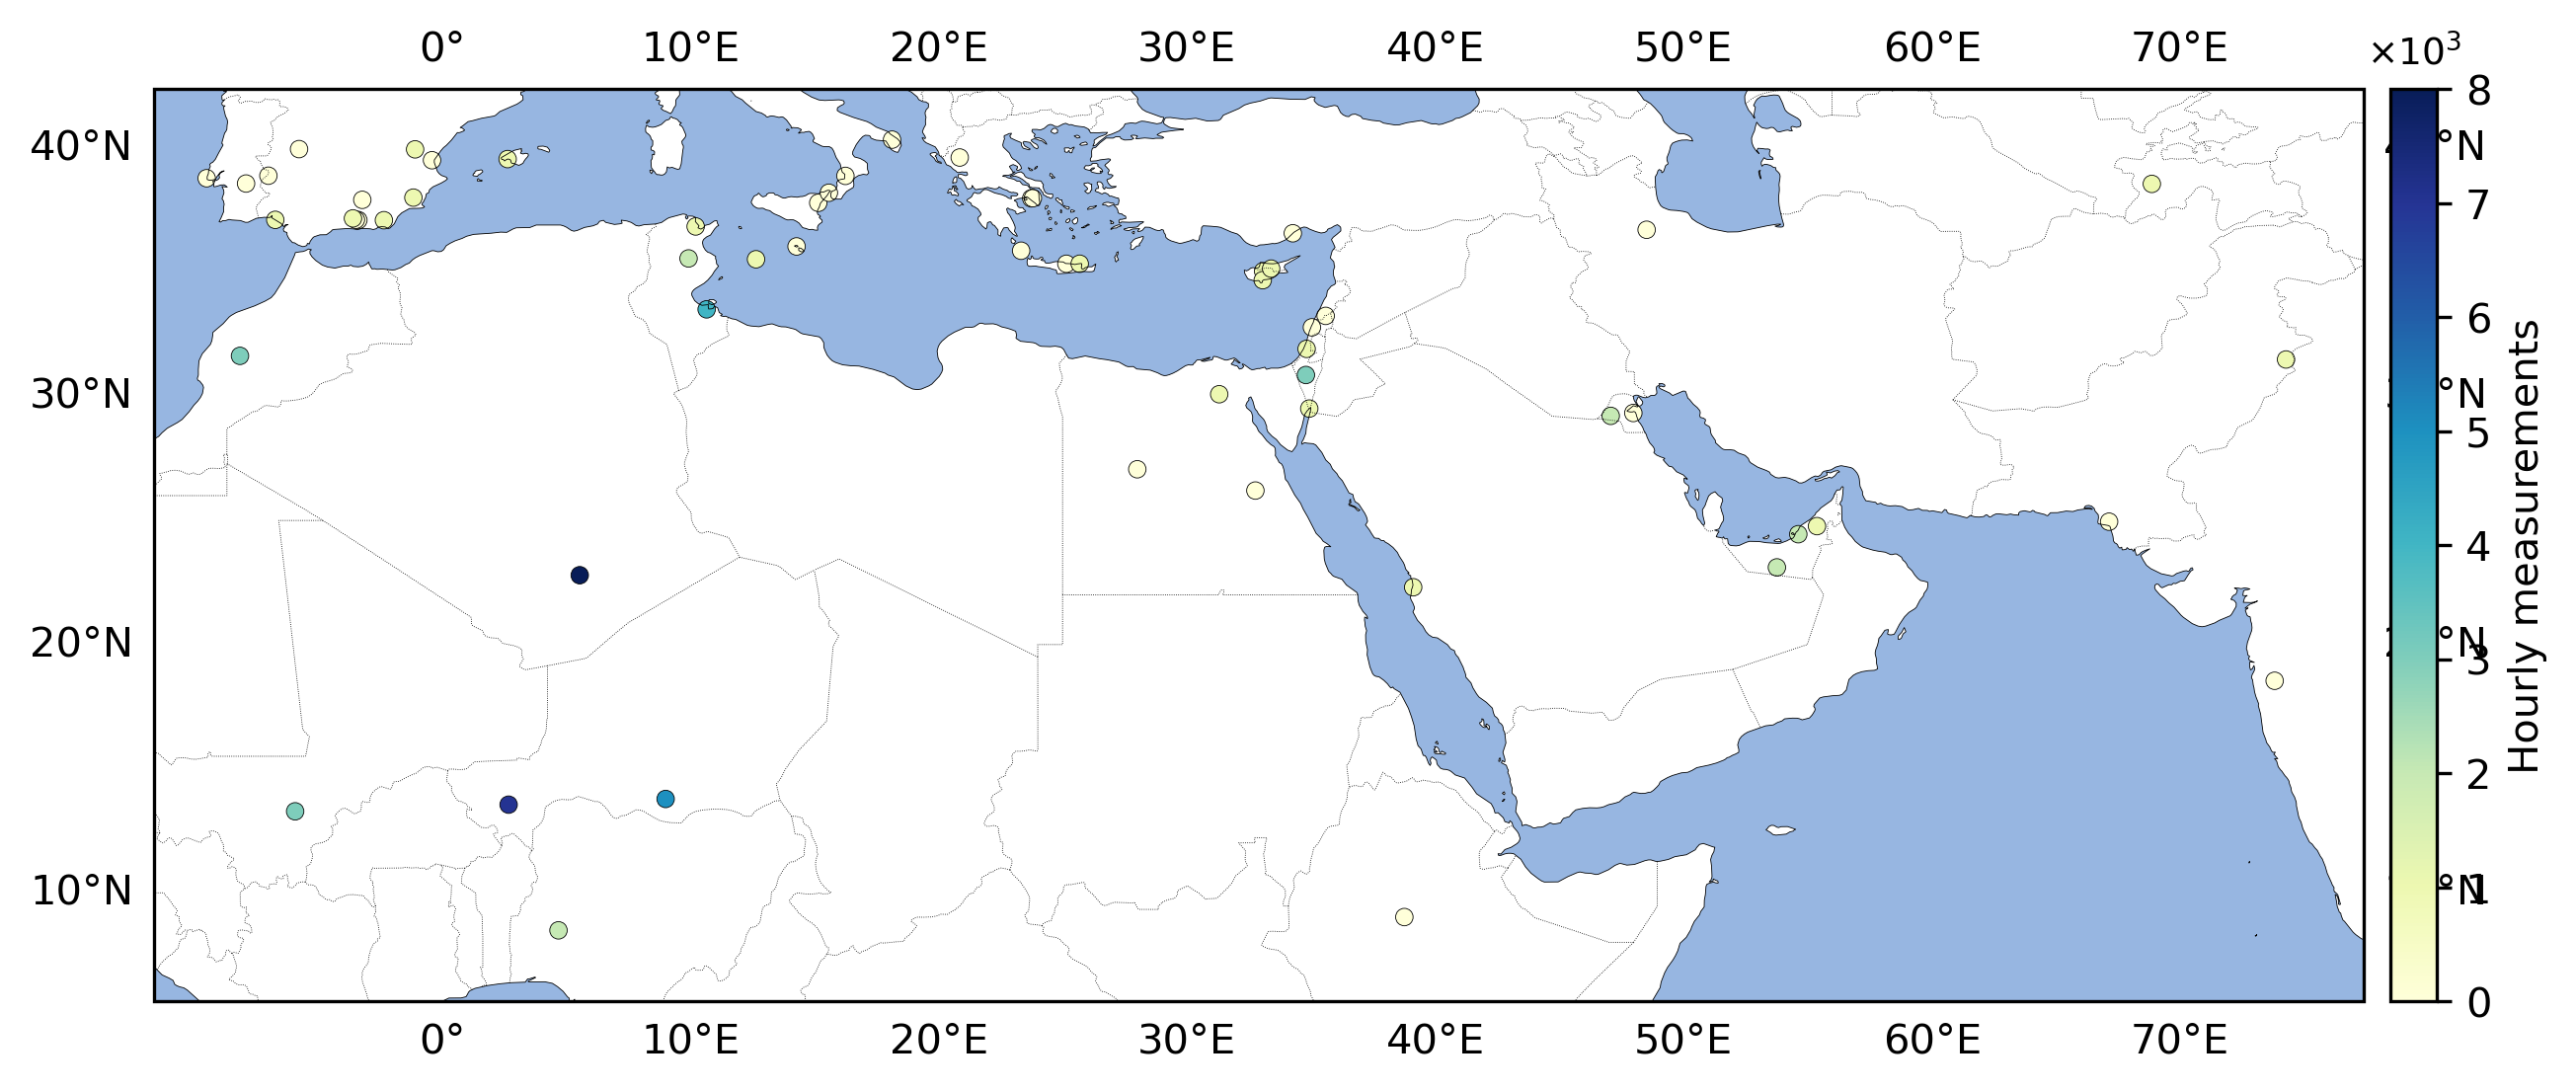

In [31]:
# Plot number of observations used in each site in a map

site_summary = concatenated_df.groupby(['site']).size().reset_index(name='hourly measurements')
site_summary = pd.merge(site_summary, aeronet, left_on='site', right_on='Site_Name')

crs=ccrs.PlateCarree()
bounds = (-11.625, 77.375, 5.625, 42.375)

plt.figure(figsize=(12,4), dpi=300)
ax = plt.axes(projection=crs)
ax.set_extent(bounds, crs)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.2)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.2)
scatter=ax.scatter(x=site_summary.lon, y=site_summary.lat, c = site_summary["hourly measurements"]//1000, s=18, transform=crs, cmap="YlGnBu", edgecolors="k" ,linewidths=0.2, alpha =1)

gl = ax.gridlines(draw_labels=True, linewidth=1, color="black", alpha=0, linestyle="--")
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(-0,100,10))
gl.ylocator = mticker.FixedLocator(np.arange(10,50,10))


cb = plt.colorbar(scatter , pad=0.01)
cb.set_label("Hourly measurements" , position="top")
cb.ax.set_title(r'$\times10^3$', fontsize=9)

plt.savefig("AERONET_Sites_Map_YlGnBu.png", bbox_inches="tight")

#
plt.show()

# Statistics

<Axes: xlabel='flag', ylabel='AOD_675nm'>

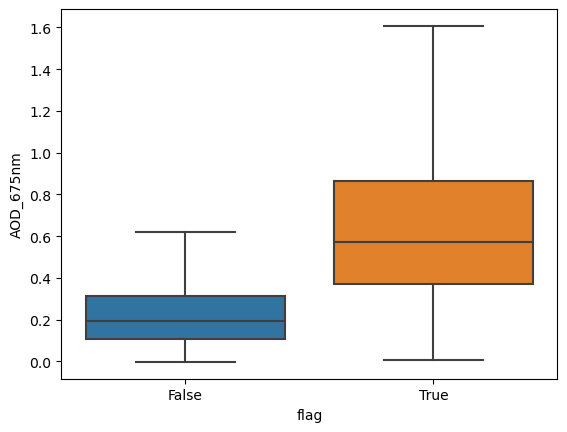

In [32]:
sns.boxplot(data = concatenated_df, y= "AOD_675nm" , x="flag", showfliers=False)	

In [33]:
# Filter to only include 'Dusty' rows
dusty_df = concatenated_df[concatenated_df['flag'] == True]

# Group by site and count the number of 'Dusty' rows for each
grouped_dusty_df = dusty_df.groupby('site').size()

# Find sites with more than 30 'Dusty' readings
sites_with_more_than_30_dusty = grouped_dusty_df[grouped_dusty_df >= 30]

# Count the number of such sites
count_of_sites_with_more_than_30_dusty = len(sites_with_more_than_30_dusty)
sites_with_more_than_30_dusty = list(sites_with_more_than_30_dusty.index)

print(f"Number of sites : {len(grouped_dusty_df)}")
print(f"Number of sites with more than 30 dusty readings: {count_of_sites_with_more_than_30_dusty}")

Number of sites : 55
Number of sites with more than 30 dusty readings: 49


In [34]:
concatenated_df['category'] = concatenated_df['flag'].map({True: 'Dust', False: 'Clear'})

t_stats=[]
p_values=[]
for site in sites_with_more_than_30_dusty:
    site_df= concatenated_df[concatenated_df.site==site]
    clear_subset = site_df[site_df['flag'] == False]['AOD_675nm'].values
    dust_subset = site_df[site_df['flag'] == True]['AOD_675nm'].values
    t_stat, p_value = ttest_ind(dust_subset, clear_subset)
    print(site, t_stat, p_value)
    t_stats.append(t_stat)
    p_values.append(p_value)
df_stats = pd.DataFrame()
df_stats["Site_Name"]= sites_with_more_than_30_dusty
df_stats["t_stat"]= t_stats
df_stats["p_value"]= p_values

ATHENS-NOA 17.266378084725524 6.0919077275543e-54
ATHENS_NTUA 9.930412861236812 1.9617282678124993e-20
AgiaMarina_Xyliatou 18.535306197815 4.3694019433434213e-69
Albergue_UGR 7.191607851850253 1.3987256376924617e-10
Antikythera_NOA 21.267751189522105 2.366000237546118e-78
Aras_de_los_Olmos 15.826962021753904 5.185448357194911e-51
Badajoz 32.20635597524842 6.737253366929564e-156
Banizoumbou 73.54320648612718 0.0
Ben_Salem 37.23192870572838 4.883512565242732e-247
Burjassot 14.672116004116118 2.6135584017576986e-43
CUT-TEPAK 28.122719845213595 9.082490898023578e-141
Cabo_da_Roca 43.17206303907008 1.250127326566217e-178
Cairo_EMA_2 19.9934045556517 6.872839113363133e-76
Cerro_Poyos 15.445813403794663 2.6623499390786606e-44
Dushanbe 28.39395554277881 2.4306071328055453e-139
Eilat 17.92282156678248 1.4995175448213522e-66
El_Arenosillo 45.612546018026585 1.3384156143665506e-278
El_Farafra 15.479783662169654 1.4368256912112205e-47
Evora 26.31803861184615 3.4546254053081765e-99
FORTH_RSLab 19.1

In [35]:
clear_subset = concatenated_df[concatenated_df['flag'] == False]['AOD_675nm'].values
dust_subset = concatenated_df[concatenated_df['flag'] == True]['AOD_675nm'].values
t_stat, p_value = ttest_ind(dust_subset, clear_subset)

In [36]:
t_stat

194.39420723394358

In [37]:
print("clear readings: " , len(clear_subset))
print("dust readings: ", len(dust_subset))

clear readings:  74906
dust readings:  12893


In [38]:
df_stats= pd.merge(aeronet, df_stats, on="Site_Name")
# Manually specify the columns to be rounded
columns_to_round = ['lon', 'lat','t_stat', 'p_value']
df_stats_rounded=df_stats.copy()
df_stats_rounded[columns_to_round] = df_stats_rounded[columns_to_round].round(2)
#df_stats_rounded.to_csv("aeronet_stats_validation.csv")

#
sorted_by_t_df = df_stats.sort_values(by='t_stat', ascending=False)

In [39]:
len(concatenated_df.site.unique())

59

In [40]:
aeronet.round(2).to_csv("aeronet_sites_info.csv")

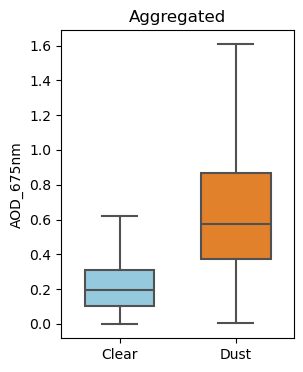

In [41]:
plt.figure(figsize=(3, 4), dpi=100)
sns.boxplot(data = concatenated_df, y= "AOD_675nm" , x="category", showfliers=False , palette={"Clear": "skyblue", "Dust": "C1"}, width=0.6)
plt.ylabel("AOD_675nm")
plt.xlabel("")
plt.title("Aggregated")
plt.show()

In [42]:
clear = concatenated_df[concatenated_df['flag'] == False]['AOD_675nm']
dust = concatenated_df[concatenated_df['flag'] == True]['AOD_675nm']

In [43]:
top_5_t   = list(sorted_by_t_df.head(5).Site_Name)
bottom_5_t=  list(sorted_by_t_df.tail(5).Site_Name)

In [44]:
# Compute the quantile values for both datasets
clear_median = np.median(clear)
clear_q1 = np.percentile(clear, 25)
clear_q3 = np.percentile(clear, 75)

clear_iqr = clear_q3 - clear_q1
clear_lower_whisker = clear_q1 - 1.5 * clear_iqr
clear_upper_whisker = clear_q3 + 1.5 * clear_iqr

#

dusty_median = np.median(dust)
dusty_q1 = np.percentile(dust, 25)
dusty_q3 = np.percentile(dust, 75)

dusty_iqr = dusty_q3 - dusty_q1
dusty_lower_whisker = dusty_q1 - 1.5 * dusty_iqr
dusty_upper_whisker = dusty_q3 + 1.5 * dusty_iqr

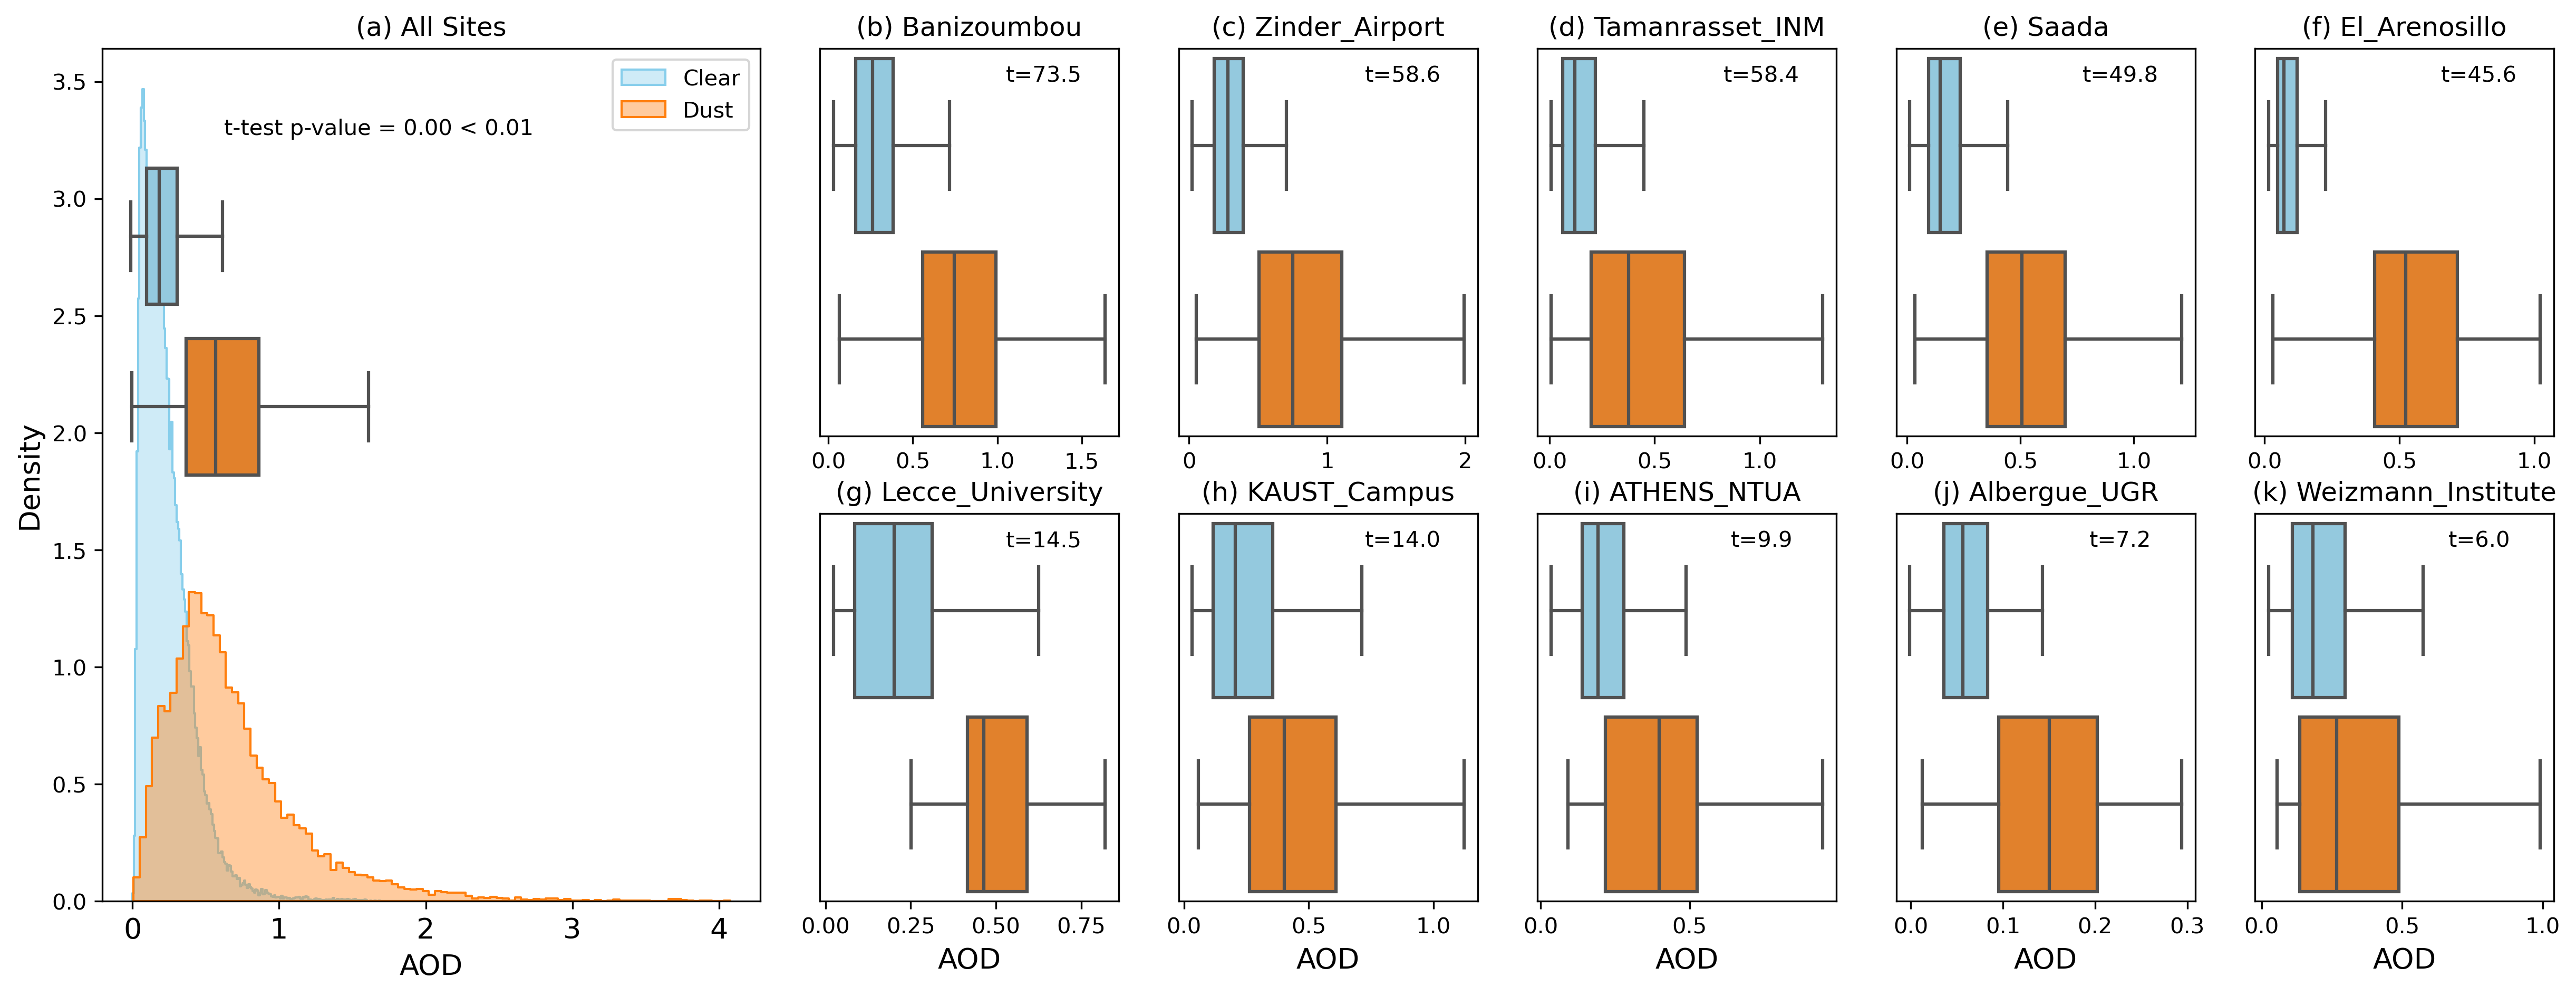

In [49]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

title_counter = iter("abcdefghijklmnopqrstuvwxyz")

# Create figure
fig = plt.figure(figsize=(20, 7), dpi=300)

# Define grid layout
gs = gridspec.GridSpec(2, 7, width_ratios=[1, 1, 1, 1, 1, 1, 1], height_ratios=[2, 2])  # 7 columns: 2 for large_ax, 5 for others

# Create a subplot that spans two rows on the left
large_ax = plt.subplot(gs[:, 0:2])
# Plotting the aggregated box plot on the left
sns.histplot(clear, label='Clear', color="skyblue", element="step", stat="density", common_norm=False, alpha=0.4)
# Plotting the distribution for Dusty category with transparency
sns.histplot(dust, label='Dust', color="C1", element="step", stat="density", common_norm=False, alpha=0.4)
large_ax.set_xlabel("AOD", size = 13)
large_ax.set_ylabel("Density", size = 13)
large_ax.set_title(f"({next(title_counter)}) " +"All Sites")
large_ax.tick_params(axis='x', labelsize=13)
large_ax.text(0.42, 0.92,f"\nt-test p-value = 0.00 < 0.01", horizontalalignment='center', verticalalignment='center', transform=large_ax.transAxes)
large_ax.legend()


ax_inset = large_ax.inset_axes([0.025, 0.48, 0.3975, 0.4])
sns.boxplot(data=[clear, dust], ax=ax_inset, orient="h", palette=["skyblue", "C1"], showfliers=False)
ax_inset.set_yticklabels([])
ax_inset.axis('off')
# Plotting the top 5 sites on the top row
for i, site in enumerate(top_5_t):
    ax = plt.subplot(gs[0, i+2])
    df = concatenated_df[concatenated_df.site==site]
    sns.boxplot(data=df, x="AOD_675nm", y="flag", showfliers=False, ax=ax ,  orient="h", palette={False: "skyblue", True: "C1"}, width=0.9)#,  orient="h")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_title(f"({next(title_counter)}) " +site)
    #
    t_stat = df_stats[df_stats['Site_Name'] == site]['t_stat'].values[0]
    
    x_position = 0.75
    y_position = 0.93
        
    ax.text(x_position, y_position, f"t={t_stat:.1f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Plotting the bottom 5 sites on the bottom row
for i, site in enumerate(bottom_5_t):
    ax = plt.subplot(gs[1, i+2])
    df = concatenated_df[concatenated_df.site==site]
    sns.boxplot(data=df, x="AOD_675nm", y="flag", showfliers=False, ax=ax ,  orient="h", palette={False: "skyblue", True: "C1"}, width=0.9)#,  orient="h")
    ax.set_ylabel("")
    ax.set_xlabel("AOD", size = 13)
    ax.set_yticks([])
    ax.set_title(f"({next(title_counter)}) " +site)
    
    t_stat = df_stats[df_stats['Site_Name'] == site]['t_stat'].values[0]

    x_position = 0.75
    y_position = 0.93
        
    ax.text(x_position, y_position, f"t={t_stat:.1f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()
